In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import string
import numpy as np


In [3]:
def sigmoid_array(x):
    # input: array
    # output: sigmoid applied to each value of input array
    return 1 / (1 + np.exp(-x))

def softmax(x):
    # input: array
    # output: softmax of array
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x))


def define_alphabet():
    # creates list of alphabet to use when parsing text data
    base_en = 'abcdefghijklmnopqrstuvwxyz'
    special_chars = ' !?¿¡' + string.punctuation + string.digits
    italian = 'àèéìíòóùú'
    french = 'àâæçéèêêîïôœùûüÿ'
    all_lang_chars = base_en + italian + french 
    small_chars = list(set(list(all_lang_chars)))
    small_chars.sort() 
    big_chars = list(set(list(all_lang_chars.upper())))
    big_chars.sort()
    small_chars += special_chars
    letters_string = ''
    letters = small_chars + big_chars
    for letter in letters:
        letters_string += letter
    return small_chars,big_chars,letters_string

alphabet, _, _ = define_alphabet()
print(alphabet, len(alphabet))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'ù', 'ú', 'û', 'ü', 'ÿ', 'œ', ' ', '!', '?', '¿', '¡', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 93


In [3]:
# fits labelBinarizer obj to alphabet so it can make one-hot encoding
# c = unique characters between eng, fre, ital = 93
le = LabelBinarizer()
le.fit(alphabet)


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [4]:
# np.random.seed(1)
# d = 100
# eta = 0.1
# input_dim = 455

# W1 = np.random.uniform(size=(d, input_dim))
# bias1 = np.random.uniform(size=[d,1])
# W2 = np.random.uniform(size=(3,d))
# bias2 = np.random.uniform(size=[3, 1])

def forward(x, W1, bias1, W2, bias2):
    hidden_layer = sigmoid_array(np.dot(W1, x.T) + bias1)
    y = softmax(np.dot(W2, hidden_layer) + bias2)
    return hidden_layer, y

# h_layer, y_pred = forward(x, W1, bias1, W2, bias2)
# y_test = np.array([1,0, 0]).reshape(3,1)
# print(W1.shape, bias1.shape, W2.shape, bias2.shape,
#       h_layer.shape, y_pred.shape, y_test.shape)

# x.shape

Questions so far
- how to know which index in softmax corresponds to which language?
- "Shuffle   your   training   data   to   prevent   the   network   overfitting   to   one   output   class."??

In [5]:
def seq_chars(s, num_chars=5):
    n = len(s)
    return [s[i:(i+num_chars)] for i in range(n-4)]

def binarize(seq_str):
    nseq = len(seq_str)
    return np.array([le.transform(list(seq_str[i])) for i in range(nseq)]).reshape(nseq, input_dim)


In [6]:
## functions for backpropogation
def grad_l_wrt_y(y_pred, y_true):
    return y_pred - y_true #(3,1)

def grad_l_wrt_b2(y_pred, y_true):
    vec = []
    for j, val in enumerate(list(y_pred)):
        counter = 0
        for i, val2 in enumerate(list(y_pred)):
            if i == j:
                counter += (y_pred[i] - y_test[i])*(y_pred[i])*(1-y_pred[j])
            else:
                counter += (y_pred[i] - y_test[i])*(y_pred[i])*(-y_pred[j])
        vec.append(counter)

                     
    return np.array(vec)

def grad_l_wrt_w2(grad_b2, hidden_layer):
    return grad_b2.dot(hidden_layer.T) #(3,1)*(1,d) is (3,d)

def grad_l_wrt_h(grad_b2, W2):
    return np.dot(W2.T, grad_b2) #(d,3)*(3,1) is (d,1)

def grad_l_wrt_h_tilde(grad_h, h_layer):
    return grad_h * ((h_layer) * (1-h_layer)) # (d,1)(elt *)(d,1) is (d,1)
#     vec = []
#     for i in range(len(h_layer)):
# #         print("mult:", grad_h[i], (h_layer[i] * (1-h_layer[i])))
#         vec.append(grad_h[i] * (h_layer[i] * (1-h_layer[i])))
#     return np.array(vec)

def grad_l_wrt_w1(grad_h_tilde, input_x):
#     x = input_x.reshape([455,])
#     h = grad_h_tilde.reshape([100,])
    
#     _, a = np.nonzero(input_x)
#     b = np.where(grad_h_tilde == 0)
#     print(a, b)
#     print('nonzero vals', x[a])
#     print('nonzero?', np.dot(grad_h_tilde, input_x)[np.nonzero(np.dot(grad_h_tilde, input_x))])
#     return np.outer(grad_h_tilde.reshape([100,]), input_x.reshape([455,]))
    return np.dot(grad_h_tilde, input_x) #(d,1)*(1,5c) is (d,5c)

def grad_l_wrt_b1(grad_h_tilde):
    return grad_h_tilde

def backprop(y_pred, y_test, h_layer, input_x, W1, W2, bias1, bias2, eta=.1):   

    grad_l_y = grad_l_wrt_y(y_pred, y_test)
#     print('grad_l_y shape is {}'.format(grad_l_y.shape))
#     print(grad_l_y)
    grad_l_b2 = grad_l_wrt_b2(y_pred, y_test)
#     print(grad_l_b2)
#     print('grad_l_b2 shape is {}'.format(grad_l_b2.shape))
    grad_l_w2 = grad_l_wrt_w2(grad_l_b2, h_layer)
#     print(grad_l_w2)
#     print('grad_l_w2 shape is {}'.format(grad_l_w2.shape))
    grad_l_h = grad_l_wrt_h(grad_l_b2, W2)
#     print(grad_l_h)
#     print('grad_l_h shape is {}'.format(grad_l_h.shape))
    grad_h_tilde = grad_l_wrt_h_tilde(grad_l_h, h_layer)
#     print(grad_h_tilde)
#     print('grad_h_tilde shape is {}'.format(grad_h_tilde.shape))
    grad_l_w1 = grad_l_wrt_w1(grad_h_tilde, input_x)
#     print(grad_l_w1)
#     print('grad_l_w1 shape is {}'.format(grad_l_w1.shape))
    grad_l_b1 = grad_l_wrt_b1(grad_h_tilde)
#     print(grad_l_b1)
#     print('grad_l_b1 shape is {}'.format(grad_l_b1.shape))

    # no error
#     print(np.nonzero(W1))
#     print(W1[np.nonzero(W1)], W1.shape)
    # confirms that there are many nonzero, but mostly 0, and that eta * grad works
#     print(grad_l_w1[np.nonzero(grad_l_w1)], (eta * grad_l_w1)[np.nonzero(eta*grad_l_w1)])
    W1 = W1 -  eta * grad_l_w1
    # this shows all rows exaclty the same except for 5, which corresponds to the 5 "1" values 
    # that were in the input
#     print(sum(sum(W1t==W1)))
    W2 = W2 - eta * grad_l_w2
    bias2 = bias2 - eta * grad_l_b2
    bias1 = bias1 - eta * grad_l_b1
#     print(np.nonzero(grad_l_w1))
#     print(grad_l_w1[np.nonzero(grad_l_w1)], grad_l_w1.shape)
#     print(np.nonzero(W1))
#     print(W1[np.nonzero(W1)], W1.shape)
    return W1, bias1, W2, bias2


# print('before backprop', W1, bias1, W2, bias2)
# print('post backprop', backprop(y_pred, y_test, h_layer, x, W1, W2,
#                                bias1, bias2))

# w1t, b1t, w2t, b2t = backprop(y_pred, y_test, h_layer, x_test, W1, W2, bias1, bias2, eta)


# # # these are exactly equal sadly...
# sum(sum(w1t!=W1))
# # np.nonzero(w1t)



# np.random.seed(1)
filename = "languageIdentification.data/train"
d = 100
eta = 0.1
input_dim = 455

W1 = np.random.uniform(size=(d, input_dim))
bias1 = np.random.uniform(size=[d,1])
W2 = np.random.uniform(size=(3,d))
bias2 = np.random.uniform(size=[3, 1])
eta = 0.1
li = []

In [16]:
for i in range(2):
    with open(filename, 'r') as handle:
        # init weights and biases

        num_chances = 0
        num_correct = 0
        for line in handle:
#             print(bias2, line)
            num_chances += 1
            s = line.split()
            label = s[0]
            sentence = ' '.join(s[1:]).lower()
            encode_mat = binarize(seq_chars(sentence))
    #         print(np.nonzero(encode_mat)[1])
    #         print("next line")
            # accumulate pred for each line, take avg, then get error
            pred = np.zeros(3)

            if label == "ENGLISH":
                y_test = np.array([0,1,0])
            elif label == "ITALIAN":
                y_test = np.array([1,0,0])
            else:
                y_test = np.array([0,0,1])

    #         # for each 5 character encoder vector
            num_rows = 0
            for row in range(len(encode_mat)):
                input_x = encode_mat[row,:].reshape(1,455)
                num_rows += 1
    #             # forward prop
                h_layer, y_pred = forward(input_x, W1, bias1, W2, bias2)
    #             # accumulate softmax
                pred += y_pred.reshape(3,)
#                 print(pred)

   

    # #         # DO THIS 3 TIMES for testing. then use W1, bias1, 
    # #         # W2, bias2 on testing data
    # #         # THIS WOULD BE DONE WHEN TESTING
    # #         # after a sentence is done
            pred_avg = pred / num_rows  # avg softmax over each 5 letter pred of sentence
    #         loss = np.square(pred_avg-y_test).sum()
    #         if loss > .3:
    #             print(loss, pred_avg, y_test, line)
    #         print('sentence done', pred, num_rows, pred_avg)
            pred_final = np.zeros(3)
    # #         # index of max prob is chosen to be one
            pred_final[np.argmax(pred_avg)] = 1
    #         print(pred_final, y_test)
    # #         # if correct guess
            if np.all(pred_final - y_test == np.array([0,0,0])):
                num_correct += 1
#                 print('yay', label)
            # im guessing we should backprop after each sentence, not after each 5 character thingy
            W1, bias1, W2, bias2 = backprop(pred_avg.reshape(3,1), y_test, h_layer, 
                                                input_x, W1, W2, bias1, bias2, eta=eta) 

    # #     # after going through all lines
    accuracy = num_correct / num_chances

    li.append(accuracy)
print(li) # hmm this should be getting better
# the problem is that I predict [1,0,0] all the time if i dont train....


/Users/jarvm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


[0.4325922117979694, 0.32155249967870453, 0.32155249967870453]


In [8]:
# # evaluate on dev
# filename_test = "languageIdentification.data/test"
# final_ans = []
# with open(filename_test, 'r') as handle:
#     # init weights and biases

#     num_chances = 0
#     num_correct = 0
#     for line in handle:
# #             print(bias2, line)
#         num_chances += 1
#         s = line.split()
# #         label = s[0]
#         sentence = ' '.join(s).lower()
#         encode_mat = binarize(seq_chars(sentence))
# #         print(np.nonzero(encode_mat)[1])
# #         print("next line")
#         # accumulate pred for each line, take avg, then get error
#         pred = np.zeros(3)

# #         if label == "ENGLISH":
# #             y_test = np.array([0,1,0])
# #         elif label == "ITALIAN":
# #             y_test = np.array([1,0,0])
# #         else:
# #             y_test = np.array([0,0,1])

# #         # for each 5 character encoder vector
#         num_rows = 0
#         for row in range(len(encode_mat)):
#             input_x = encode_mat[row,:].reshape(1,455)
#             num_rows += 1
# #             # forward prop
#             h_layer, y_pred = forward(input_x, W1, bias1, W2, bias2)
# #             # accumulate softmax
#             pred += y_pred.reshape(3,)
# #             print(pred)



# # #         # DO THIS 3 TIMES for testing. then use W1, bias1, 
# # #         # W2, bias2 on testing data
# # #         # THIS WOULD BE DONE WHEN TESTING
# # #         # after a sentence is done
#         pred_avg = pred / num_rows  # avg softmax over each 5 letter pred of sentence
# #         loss = np.square(pred_avg-y_test).sum()
# #         if loss > .3:
# #             print(loss, pred_avg, y_test, line)
# #         print('sentence done', pred, num_rows, pred_avg)
#         pred_final = np.zeros(3)
# # #         # index of max prob is chosen to be one
#         pred_final[np.argmax(pred_avg)] = 1
#         final_ans.append(pred_final)
# #         if pred_final == np.array([0,1,0]):
# #             lab = 'ENGLISH'
# #         elif label == np.array([1,0,0]):
# #             lab = 'ITALIAN'
# #         else:
# #             lab = 'FRENCH'

# #         print(pred_final, y_test)
# # #         # if correct guess
# #         if np.all(pred_final - y_test == np.array([0,0,0])):
# #             num_correct += 1
# #                 print('yay', label)
#         # im guessing we should backprop after each sentence, not after each 5 character thingy
# #         W1, bias1, W2, bias2 = backprop(pred_avg.reshape(3,1), y_test, h_layer, 
# #                                             input_x, W1, W2, bias1, bias2, eta=eta) 

# # #     # after going through all lines
# # accuracy = num_correct / num_chances

# # li.append(accuracy)
# # print(li) # hmm this should be getting better
# # the problem is that I predict [1,0,0] all the time if i dont train....


In [9]:
# # example of an input 'x' which is 5c,1
# # c = unique characters between eng, fre, ital = 93
# le = LabelEncoder()
# oe = OneHotEncoder(sparse=False)
# int_encoded = le.fit_transform(np.array(alphabet))
# int_encoded = int_encoded.reshape(len(int_encoded),1)
# # s = list('ggéré'.lower())
# # x = le.transform(s)
# x = oe.fit_transform(int_encoded)
# # print(x, x.shape)

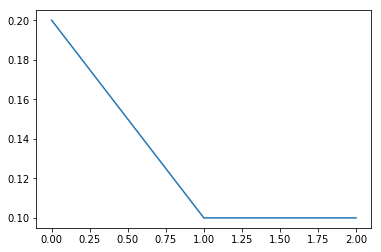

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.array(li))
plt.show()